# Uncovering city's budget spending on municipal employees payment





**Project Objective:** Our goal is to analyze and determine how the City's financial resources are distributed and how much of the budget is spent on overtime. 

**Motivation:** For the workers, they will benefit from knowing the allocations and average payment of municipal jobs in New York city, while the public will be interested in knowing how the city's budget is being spent. City planners could use this analysis to allocate promotions and fair salaries across different agencies. We will use Linear Regression Model to uncover the statistical relations between tenure, work hours, OT time, locations to predict gross salary of the worker.

Data source: https://data.cityofnewyork.us/City-Government/Citywide-Payroll-Data-Fiscal-Year-/k397-673e


##  Approaches: Full data analysis cycle

**1.   Data preparation**
*   Data source piping to Big Query and Colab
*   Identify data anomalies
*   Interrogate column properties
*   Resolve inconsistencies, unexpected or null values, and data quality issues

**2.   Data modelling**
*   Remove unnecessary rows and columns
*   Define a relationship's cardinality and cross-filter direction
*   Create a common date table
*   Create calculated columns

**3. Data Analytics**
*   Apply slicers and filters
*   Perform top N analysis
*   Explore statistical summary
*   Identify outliers
*   Conduct Time Series analysis
*   Use groupings and binnings
*   Apply AI Insights

**4. Data visualization**
*   Add visualization items to sheets and dashboards
*   Choose an appropriate visualization type
*   Apply slicing and filtering
*   Apply sorting 
*   Configure data classification
*   Drilldown into data using interactive visuals
*   Mobile view
*   Publish


















## 1. Data Preparation





### Data Piping

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
%%bigquery --project=ba-775-b2-team-3
SELECT * FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll` LIMIT 5

,Fiscal_Year,Payroll_Number,Agency_Name,Last_Name,First_Name,Mid_Init,Agency_Start_Date,Work_Location_Borough,Title_Description,Leave_Status_as_of_June_30,Base_Salary,Pay_Basis,Regular_Hours,Regular_Gross_Paid,OT_Hours,Total_OT_Paid,Total_Other_Pay
0,2014,2,OFFICE OF THE MAYOR,CAPORALE,CAITLIN,None,2008-07-07,None,RESEARCH PROJECTS COORD,ACTIVE,74400.0,per Annum,1825.0,63161.81,0.0,0.0,0.0
1,2014,2,OFFICE OF THE MAYOR,CUMMINGS,KEVIN,S,2010-03-17,None,SPECIAL ASSISTANT,ACTIVE,85000.0,per Annum,1825.0,83769.76,0.0,0.0,0.0
2,2014,2,OFFICE OF THE MAYOR,MOORE,KARA,D,2010-07-26,None,SPECIAL ASSISTANT,CEASED,126500.0,per Annum,919.0,75941.94,0.0,0.0,500.0
3,2014,2,OFFICE OF THE MAYOR,SPAVINS,JOHN,C,2011-06-06,None,RESEARCH PROJECTS COORD,CEASED,110000.0,per Annum,919.0,111736.24,0.0,0.0,0.0
4,2014,2,OFFICE OF THE MAYOR,DUNCAN,CHARLA,A,2013-01-09,None,MAYORAL OFFICE ASSISTANT,CEASED,20.0,per Hour,0.0,1626.33,0.0,65.0,0.0


### Column Properties






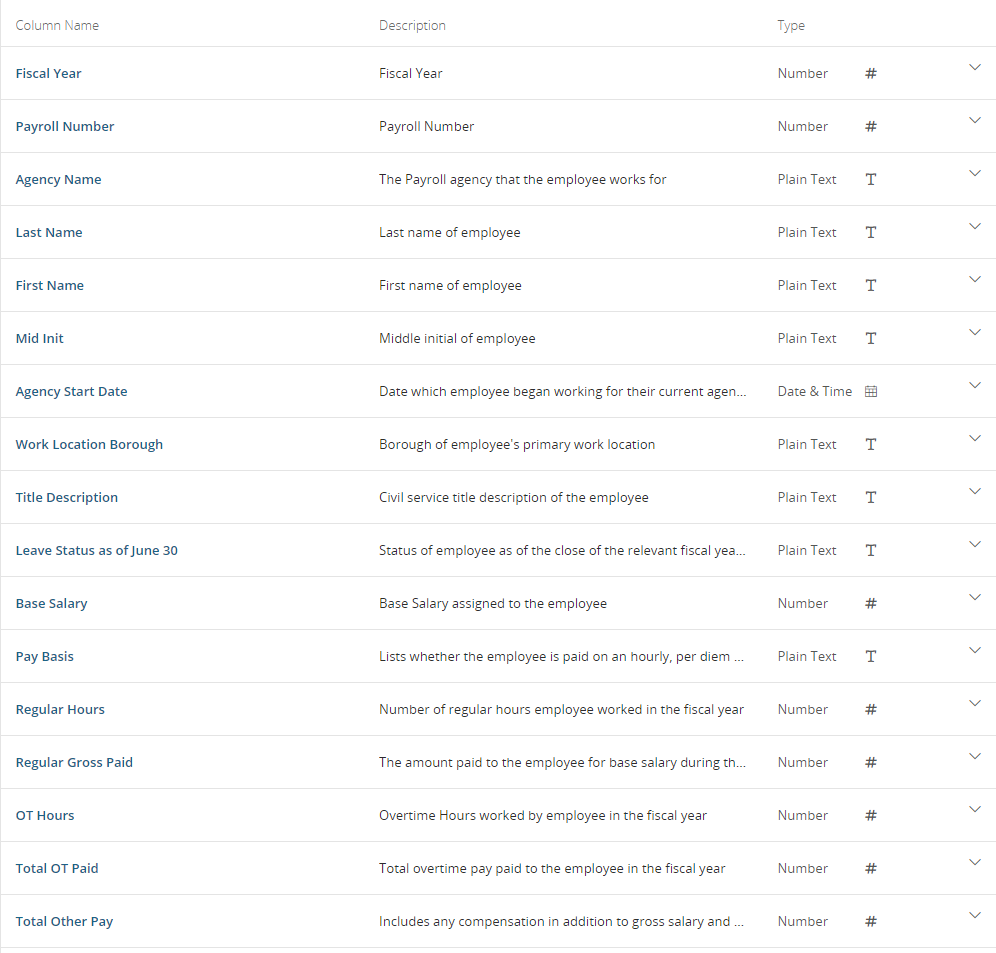

### Data anomolities: 

*   Title_Description has a lot of strange characters (see below code)
*   Agency_start_date = null
*   Work_location_borough = null
*   regular_hours < 0
*   Regular_Gross_Paid < 0
*   OT_Hours < 0
*   Total_OT_Paid < 0
*   Total_Other_Pay < 0



In [ ]:
%%bigquery --project=ba-775-b2-team-3
SELECT DISTINCT Title_Description FROM ba-775-b2-team-3.NYC_Payroll.NYC_Payroll
WHERE REGEXP_CONTAINS(Title_Description, '[^0-9A-Za-z --\']')
ORDER BY Title_Description

LIMIT 5

,Title_Description
0,*DIRECTOR OF HEALTH CARE PROGRAM PLANNING/ANAL...
1,12 MONTH SPECIAL EDUCATION ASST. PRINCIPAL
2,?*COMMUNITY LIAISON WORKER
3,?*DENTIST
4,?*ELEVATOR OPERATOR


## 2. Data Cleaning and Data modelling

* In the raw data we have a common date table called "Agency_Start_Date" that has the data type of date-time and YYYY-MM-DD. We will create a caculated column called "Tenure" to specify the number of years that a person has stayed in the company, with the Tenure = 2021 - YYYY

* We will also create another new caculated column called "Total_Salary", with Total_Salary = Regular_Gross_Paid + Total_OT_paid + Total_Other_Pay

(We would have liked to use the column (Pay_Bases and Regular_Hours to calculate with the presumption that Base_Salary * Regular_Hours = Regular_Gross_Paid but some of the data didn't match)

* Work_location_borough has a hierarchy and will be set like this:
> New York State
> - ULSTER
> - NASSAU
> - WESTCHESTER
> - NYC
>   - BROOKLYN
    - MANHATTAN
    - QUEENS
    - BRONX
    - RICHMOND
> - SULLIVAN
> - SCHOHARIE
> - DUTCHESS
> - ALBANY

Also Work_location_borough has both uppercase and downcase so we will use UPPER() when GROUP BY()

### Cleaning code

In [ ]:
# This is the query that we put in BigQuery to create a New clean table 
# Don't run it or it will cost a lot of minutes of your life

# %%bigquery --project=ba-775-b2-team-3
CREATE OR REPLACE TABLE ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned
AS
SELECT 
  Fiscal_Year,
  Agency_Name,
  Agency_Start_Date,
  EXTRACT(year FROM Agency_Start_Date) AS Year,
  2021 - EXTRACT(year FROM Agency_Start_Date) AS Tenure,
  EXTRACT (month FROM Agency_Start_Date) AS Month_Numeric,
  FORMAT_DATETIME("%B", Agency_Start_Date) Month_Alphabet,
  Work_Location_Borough,
  Leave_Status_as_of_June_30,
  Base_Salary, 
  Pay_Basis,
  Regular_Hours, 
  Regular_Gross_Paid,
  OT_Hours,
  Total_OT_Paid,
  Total_Other_Pay,
  Regular_Gross_Paid + Total_OT_paid + Total_Other_Pay AS Total_Salary,
  regexp_replace(Title_Description, '[?*]', '') AS Title_Description


FROM ba-775-b2-team-3.NYC_Payroll.NYC_Payroll
-- WHERE REGEXP_CONTAINS(Title_Description, '[^0-9A-Za-z --\']')


WHERE Title_Description IS NOT NULL 
AND Fiscal_Year IS NOT NULL 
AND Agency_Start_Date IS NOT NULL
AND Work_Location_Borough IS NOT NULL
AND Leave_Status_as_of_June_30 IS NOT NULL
AND Base_Salary IS NOT NULL 
AND Base_Salary > 0
AND Pay_Basis IS NOT NULL
AND Regular_Hours IS NOT NULL 
AND Regular_Hours > 0
AND Regular_Gross_Paid IS NOT NULL
AND Regular_Gross_Paid > 0
AND OT_Hours IS NOT NULL
And OT_Hours > 0
AND Total_OT_Paid IS NOT NULL
AND Total_OT_Paid > 0
AND Total_Other_Pay IS NOT NULL
AND Total_Other_Pay > 0

### The clean table

Finally, we have a clean table called "NYC_Payroll_Cleaned" and we will use this clean table for further data analytics

In [ ]:
%%bigquery --project=ba-775-b2-team-3
SELECT * FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned` LIMIT 5

,Fiscal_Year,Agency_Name,Agency_Start_Date,Year,Tenure,Month_Numeric,Month_Alphabet,Work_Location_Borough,Leave_Status_as_of_June_30,Base_Salary,Pay_Basis,Regular_Hours,Regular_Gross_Paid,OT_Hours,Total_OT_Paid,Total_Other_Pay,Total_Salary,Title_Description
0,2017,POLICE DEPARTMENT,1980-07-07,1980,41,7,July,RICHMOND,ACTIVE,41391.00,per Annum,1795.00,42538.65,2.0,50.32,9006.22,51595.19,POLICE ADMINISTRATIVE AIDE
1,2015,DEPT OF ENVIRONMENT PROTECTION,1981-12-01,1981,40,12,December,QUEENS,ACTIVE,85019.00,per Annum,2084.57,88853.74,28.5,1978.33,8525.25,99357.32,SUPERVISOR
2,2015,NYC HOUSING AUTHORITY,1983-04-27,1983,38,4,April,MANHATTAN,CEASED,324.72,per Day,1068.57,71157.33,120.0,9132.75,804.23,81094.31,PLASTERER
3,2017,POLICE DEPARTMENT,1983-04-27,1983,38,4,April,QUEENS,ACTIVE,50696.00,per Annum,1795.00,49593.33,232.0,8121.05,4991.30,62705.68,SENIOR POLICE ADMINISTRATIVE AIDE
4,2019,POLICE DEPARTMENT,1983-04-27,1983,38,4,April,QUEENS,ACTIVE,52908.00,per Annum,1785.00,53223.48,113.0,4281.41,5332.40,62837.29,SENIOR POLICE ADMINISTRATIVE AIDE


## 3. Data Analytics

Asking the real question: who would benefit from seeing this data?

### IAMA Job seeker

The "Job seeker" will be one of the types of people to benefit from analyzing this dataset. The "Job seeker" will be interested in topics such as: how are jobs allocated between different locations, what is the average salary between different locations, job titles and tenures. 

We will first take a look at the dataset, then analyze the average salary of workers through three key facts: work location, job description and tenure.



#### Dive in the dataset

Firstly, we will take a look at the trends of maximum, minimum and average total salary over the period from 2014 to 2020.

- Conclusion：From the line graph, the trends of minimum salary and average salary maintain at the same level throughout the years. It can be explained as the economic environment and other factors didn't have an impact on the minimum and average salary of municipal employees in New York States. However, the maximum salary that New York States can pay for workers fluctuates with a sudden decrease around 2018 to 2019. From the bar chart, we found that the top 5 boroughs with the most active employees that are: Manhattan, Queens, Brooklyn, Bronx and Richmond.



In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project = 'ba-775-b2-team-3')

In [ ]:
sql = """
SELECT 
  Fiscal_Year, 
  CAST(MAX(Total_Salary) AS INT) AS Max_Total_Salary, 
  CAST(MIN(Total_Salary) AS INT) AS Min_Total_Salary , 
  CAST(AVG(Total_Salary) AS INT) AS Avg_Total_Salary 
FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned` 
GROUP BY Fiscal_Year 
ORDER BY Fiscal_Year ASC

"""
df_1 = client.query(sql).to_dataframe()
df_1

,Fiscal_Year,Max_Total_Salary,Min_Total_Salary,Avg_Total_Salary
0,2014,118709,3954,51966
1,2015,274352,263,80283
2,2016,400663,315,85428
3,2017,373904,317,86814
4,2018,539098,187,84056
5,2019,310216,143,83960
6,2020,348888,232,86183


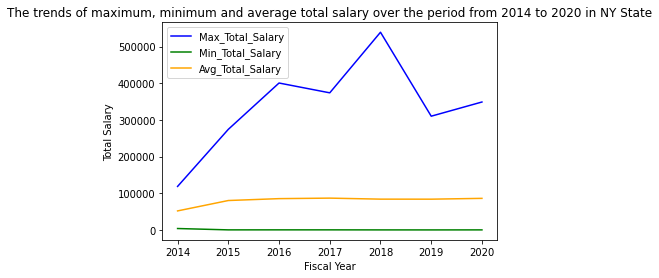

In [ ]:
import matplotlib.pyplot as plt
plt.plot( df_1.Fiscal_Year,df_1.Max_Total_Salary, 'b', label='Max_Total_Salary')
plt.plot( df_1.Fiscal_Year,df_1.Min_Total_Salary, 'g', label='Min_Total_Salary')
plt.plot( df_1.Fiscal_Year,df_1.Avg_Total_Salary, 'orange', label='Avg_Total_Salary')

plt.xlabel("Fiscal Year")
plt.ylabel("Total Salary")
plt.title('The trends of maximum, minimum and average total salary over the period from 2014 to 2020 in NY State')
plt.legend()
plt.show()

* Analyze the proportion of current active employees at different locations using plt.pie()



In [ ]:
sql = """
SELECT COUNT(*) AS NUM_EMPLOYEEE, UPPER(Work_Location_Borough) as Work_Location
FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
WHERE Leave_Status_as_of_June_30 = "ACTIVE"
GROUP BY Work_Location
ORDER BY NUM_EMPLOYEEE DESC
LIMIT 5
"""
df_2_a = client.query(sql).to_dataframe()
df_2_a


,NUM_EMPLOYEEE,Work_Location
0,247209,MANHATTAN
1,196668,QUEENS
2,180468,BROOKLYN
3,99256,BRONX
4,30953,RICHMOND


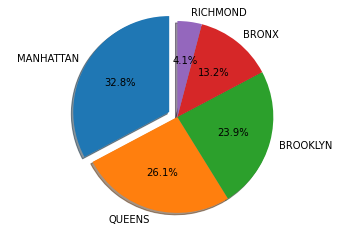

In [ ]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = df_2_a['Work_Location'].to_list()
sizes = df_2_a['NUM_EMPLOYEEE'].to_list()
explode = (0.1, 0, 0, 0,0)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode = explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

#### Analyzing the correlation of average salary between three key factors

We will analyze the relationships between average salary over three key factors:

- a. Work Location
- b. Title Description
- c. Tenure

a. Work Location
- Top 1 list of locations with the highest average total salary from 2015 to 2020
- Count the number of appearances of each work location from the Top 5 List of best locations with highest salaries


`Conclusion:`
- From the table we can see the top locations with the highest salaries during the period of 2015 - 2020
- These are the locations with their number of appearances in the top 5 list of locations with highest salaries: RICHMOND(7), DUTCHESS(6), and QUEENS(6). Especially, RICHMOND(7) is on the top 5 list for a 7th consecutive year.


In [ ]:
#With rn = 1 (as in get the worklocation with largest avg_total_salary) it's better to just use GROUP BY and ORDER BY
#But if you want to get top 5 list in each year, change it to 1 <= rn <= 5

%%bigquery --project=ba-775-b2-team-3

SELECT * FROM 
  (SELECT *, 
    ROW_NUMBER() OVER (PARTITION BY Fiscal_Year ORDER BY Avg_Total_Salary DESC) as rn
  FROM(
    SELECT 
      Fiscal_Year,
      CAST(AVG(Total_Salary) AS INT64 ) AS Avg_Total_Salary,
      UPPER(Work_Location_Borough) AS Work_Location,
    FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
    WHERE  UPPER(Work_Location_Borough) IS NOT NULL
    AND Fiscal_Year >= 2015
    GROUP BY 	Work_Location, Fiscal_Year
    ORDER BY Fiscal_Year ASC, Avg_Total_Salary DESC
    )
  )
WHERE rn = 1
ORDER BY Fiscal_Year DESC


,Fiscal_Year,Avg_Total_Salary,Work_Location,rn
0,2020,116991,ALBANY,1
1,2019,101882,GREENE,1
2,2018,168882,ALBANY,1
3,2017,97443,DUTCHESS,1
4,2016,157600,ORANGE,1
5,2015,110234,ORANGE,1


In [ ]:


%%bigquery --project=ba-775-b2-team-3

WITH Work_Location_Table
AS(SELECT * FROM 

  (SELECT 
    *, 
    ROW_NUMBER() OVER (PARTITION BY Fiscal_Year ORDER BY Avg_Total_Salary DESC) as rn
  FROM(
    SELECT 
      Fiscal_Year,
      CAST(AVG(Total_Salary) AS INT64 ) AS Avg_Total_Salary,
      Work_Location_Borough,
    FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
    WHERE 	Work_Location_Borough IS NOT NULL
    GROUP BY 	Work_Location_Borough, Fiscal_Year
    ORDER BY Fiscal_Year ASC, Avg_Total_Salary DESC))
  
  WHERE rn >=1 and rn <=5
  ORDER BY Fiscal_Year DESC)

SELECT UPPER(Work_Location_Borough) AS Work_Location, COUNT(UPPER(Work_Location_Borough)) AS Appearances_in_top_5_Salary
FROM Work_Location_Table
GROUP BY Work_Location
ORDER BY Appearances_in_top_5_Salary DESC
LIMIT 5

b. Title Description

- Top 1 Title Descriptions with the highest earnings over the fiscal year from 2015 to 2020

- Count the number of apperances of each Title Description from the Top 5 list of best job titles with the highest salaries


`Conclusion:`
- From the table we can see the top job titles with the highest earnings during the period of 2015 - 2020
- These are the job titles with their number of appearances in the top 5 list of titles with highest earnings: CRANE OPERATOR AMPES	(4), CITY MEDICAL EXAMINER(4), and SENIOR SYSTEMS ANALYSTS(3). 



In [ ]:
%%bigquery --project=ba-775-b2-team-3

SELECT * FROM 

  (SELECT 
    *, 
    ROW_NUMBER() OVER (PARTITION BY Fiscal_Year ORDER BY Avg_Total_Salary DESC) as rn
  FROM(
    SELECT 
      Fiscal_Year,
      CAST(AVG(Total_Salary) AS INT64 ) AS Avg_Total_Salary,
      Title_Description,
    FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
    WHERE Title_Description IS NOT NULL
    AND Fiscal_Year >= 2015
    GROUP BY Title_Description, Fiscal_Year
    ORDER BY Fiscal_Year ASC, Avg_Total_Salary DESC
    )
  )

WHERE rn = 1
ORDER BY Fiscal_Year DESC



,Fiscal_Year,Avg_Total_Salary,Title_Description,rn
0,2020,282477,SENIOR SYSTEMS ANALYSTS,1
1,2019,222760,CITY MEDICAL EXAMINER,1
2,2018,301472,SENIOR STATIONARY ENGINEER,1
3,2017,209358,CITY MEDICAL EXAMINER,1
4,2016,400663,SUPERVISOR SHIP CARPENTER,1
5,2015,194307,SUPERVISOR DOCKBUILDER,1


In [ ]:
%%bigquery --project=ba-775-b2-team-3
WITH Top_5_AVG_Salary_by_title_year
AS(SELECT * FROM 

    (SELECT 
      *, 
      ROW_NUMBER() OVER (PARTITION BY Fiscal_Year ORDER BY Avg_Total_Salary DESC) as rn
    FROM
      (
      SELECT 
        Fiscal_Year,
        CAST(AVG(Total_Salary) AS INT64 ) AS Avg_Total_Salary,
        Title_Description,
      FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
      WHERE Title_Description IS NOT NULL
      GROUP BY Title_Description, Fiscal_Year
      ORDER BY Fiscal_Year ASC, Avg_Total_Salary DESC
      )
    )

  WHERE rn >=1 and rn <=5
  ORDER BY Fiscal_Year DESC)

SELECT Title_Description, COUNT(Title_Description) AS Times_in_top_5_salary
FROM Top_5_AVG_Salary_by_title_year
GROUP BY Title_Description
ORDER BY Times_in_top_5_salary DESC
LIMIT 5


,Title_Description,Times_in_top_5_salary
0,CRANE OPERATOR AMPES,4
1,CITY MEDICAL EXAMINER,4
2,SENIOR SYSTEMS ANALYSTS,3
3,SENIOR STATIONARY ENGINEER,3
4,SUPERVISOR DOCKBUILDER,3


c. Tenure

- Top tenures which makes the most salaries over 2015 - 2020

- Count the number of appearances of each tenure from the Top 5 List

- Diagrams of OT hours for different tenures between the 3 most recent years

`Conclusion:`
- Over the fiscal year from 2015 to 2020, the people who have stayed in their jobs for 26 years have higher salaries than others in NY States. 

- We can see that if the tenure of a person is around 20 - 30 years, he or she will have a higher chance of making the most money (as seen in the appearance numbers in top 5 list tenures with the highest earnings). 

- From the diagrams of OT hours between 3 recent years, we can see that during 2018, 2019 and 2020, the trend of OT hours will stay the same. Also, there will be a sudden peak in OT hours when the person reaches the age of 50.

In [ ]:
%%bigquery --project=ba-775-b2-team-3
SELECT * FROM 

  (SELECT 
    *, 
    ROW_NUMBER() OVER (PARTITION BY Fiscal_Year ORDER BY Avg_Total_Salary DESC) as rn
  FROM(
    SELECT 
      Fiscal_Year,
      CAST(AVG(Total_Salary) AS INT64 ) AS Avg_Total_Salary,
      Tenure,
    FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
    WHERE Tenure IS NOT NULL
    AND Fiscal_Year >= 2015
    GROUP BY Tenure, Fiscal_Year
    ORDER BY Fiscal_Year ASC, Avg_Total_Salary DESC
    )
  )

WHERE rn = 1
ORDER BY Fiscal_Year DESC

,Fiscal_Year,Avg_Total_Salary,Tenure,rn
0,2020,126650,26,1
1,2019,123388,26,1
2,2018,167223,57,1
3,2017,125508,26,1
4,2016,118546,26,1
5,2015,115860,26,1


In [ ]:
%%bigquery --project=ba-775-b2-team-3
WITH Tenure_Salary_Table
AS(SELECT * FROM 

    (SELECT 
      *, 
      ROW_NUMBER() OVER (PARTITION BY Fiscal_Year ORDER BY Avg_Total_Salary DESC) as rn
    FROM
      (
      SELECT 
        Fiscal_Year,
        CAST(AVG(Total_Salary) AS INT64 ) AS Avg_Total_Salary,
        Tenure,
      FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
      WHERE Tenure IS NOT NULL
      GROUP BY Tenure, Fiscal_Year
      ORDER BY Fiscal_Year ASC, Avg_Total_Salary DESC
      )
    )

  WHERE rn >=1 and rn <=5
  ORDER BY Fiscal_Year DESC)

SELECT Tenure, COUNT(Tenure) AS Appearances_in_top_5_salary
FROM Tenure_Salary_Table
GROUP BY Tenure
ORDER BY Appearances_in_top_5_salary DESC

LIMIT 5


,Tenure,Appearances_in_top_5_salary
0,26,6
1,30,6
2,24,6
3,27,6
4,29,2


In [ ]:
sql = """
SELECT 
  data_2018.Tenure, 
  Avg_OT_2018, 
  Avg_OT_2019, 
  Avg_OT_2020 
FROM
  (SELECT 
      Tenure as tenure, 
      CAST (AVG (OT_Hours) AS INT64) AS Avg_OT_2018
  FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
  WHERE Fiscal_Year = 2018
  GROUP BY Tenure
  ORDER BY Tenure DESC) data_2018

  JOIN

  (SELECT 
      Tenure as tenure, 
      CAST (AVG (OT_Hours) AS INT64) AS Avg_OT_2019
  FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
  WHERE Fiscal_Year = 2019
  GROUP BY Tenure
  ORDER BY Tenure DESC) data_2019

  ON data_2018.tenure = data_2019.tenure

  JOIN

  (SELECT 
      Tenure as tenure, 
      CAST (AVG (OT_Hours) AS INT64) AS Avg_OT_2020
  FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
  WHERE Fiscal_Year = 2020
  GROUP BY Tenure
  ORDER BY Tenure DESC) data_2020

  ON data_2018.tenure = data_2020.tenure
ORDER BY Tenure DESC
"""
data = client.query(sql).to_dataframe()
data

,Tenure,Avg_OT_2018,Avg_OT_2019,Avg_OT_2020
0,56,29,33,97
1,55,316,308,86
2,54,57,34,23
3,53,141,240,133
4,51,290,60,44
5,50,138,347,304
6,49,150,127,150
7,48,110,110,80
8,47,61,71,42
9,46,169,131,88


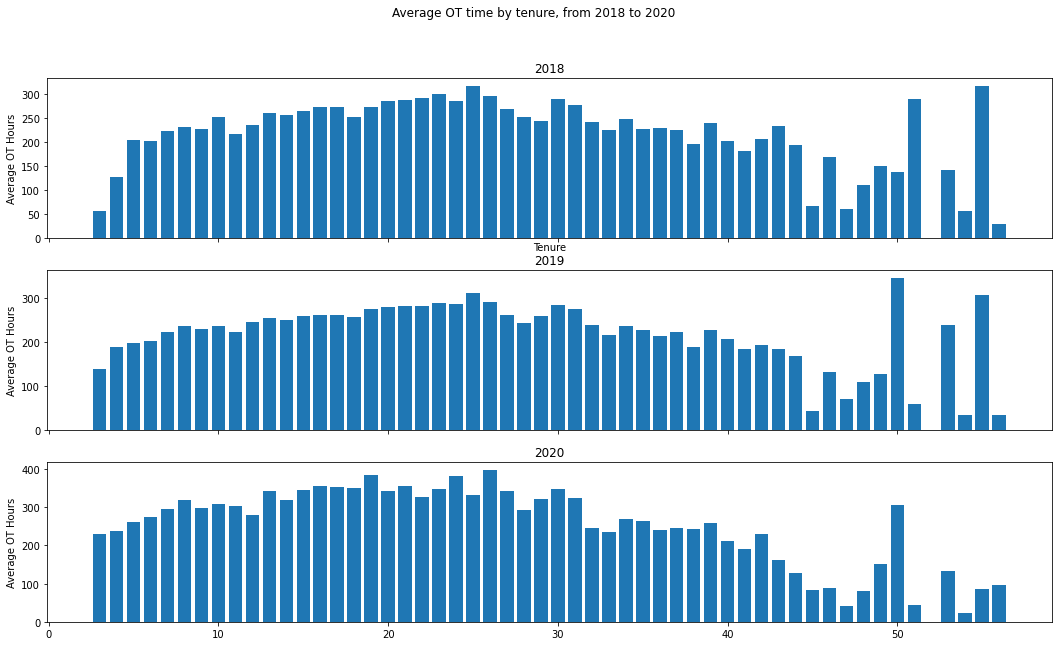

In [ ]:
import matplotlib.pyplot as plt
fig, (data_2018, data_2019, data_2020) = plt.subplots(3, 1, sharex=True)
fig.suptitle('Average OT time by tenure, from 2018 to 2020')
fig.set_figheight(10)
fig.set_figwidth(18)

data_2018.bar(data['Tenure'],data['Avg_OT_2018'])
data_2018.set_xlabel('Tenure')
data_2018.set_ylabel('Average OT Hours')
data_2018.set_title('2018')

data_2019.bar(data['Tenure'],data['Avg_OT_2019'])
data_2019.set_ylabel('Average OT Hours')
data_2019.set_title('2019')

data_2020.bar(data['Tenure'],data['Avg_OT_2020'])
data_2020.set_ylabel('Average OT Hours')
data_2020.set_title('2020')

plt.show()

### IAMA NYC Citizen

#### Analyzing the NYC citizen

The "NYC citizen" will be the second type to benefit from this dataset. The "NYC citizen" will be interested in topics such as: How did the government spend money on salary of how many people? And the difference in spending according to locations.

`Conclusions:`


*   In 2020, the top 5 boroughs with the highest total salary includes Manhattan, Queens, Brooklyn, Bronx, and Richmond.
*   Throughout 2015-2020, salary allocation increased the most from 2015 - 2016 with a 7.48% increase. Most increases were less than 10% with a decrease in 0.28% from 2018 to 2019.



*   Manhattan, Queens, Brooklyn, Bronx and Richmond (essentially 5 boroughs of NYC) have the most number of active employees and thus having the top budget spent.
*   The 3 most agency with the biggest spending are: Pubic Administrator Kings, Tax Commission and Fire Department. Interestingly, the two first agency only have very few number of employees with more budget spending than the whole fire department combined, which will pose some interesting questions if we decide to do more research on this matter.



#### Code to research on the allocation of budget through time, location, number of employees and agency 

* Allocation of budget in different locations in the year 2020











In [ ]:
%%bigquery --project=ba-775-b2-team-3
SELECT 
  Work_Location_Borough, 
  CAST(sum(total_salary) as int64) as budget_allocation
FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
WHERE fiscal_year = 2020
GROUP BY Work_Location_Borough
ORDER BY budget_allocation DESC

LIMIT 5

,Work_Location_Borough,budget_allocation
0,MANHATTAN,4278322055
1,QUEENS,3197360476
2,BROOKLYN,2853076825
3,BRONX,1543939975
4,RICHMOND,532132970


* Changes in budget allocation during the years

In [ ]:
%%bigquery --project=ba-775-b2-team-3
WITH budget AS(
SELECT 
  fiscal_year
  , 
  CAST(SUM(total_salary) AS INT64) AS budget_allocation

FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
WHERE fiscal_year <> 2014
GROUP BY Fiscal_Year)

SELECT 
    fiscal_year, budget_allocation,
    ((budget_allocation - LAG(budget_allocation,1) OVER(ORDER BY fiscal_year))/lag(budget_allocation,1) OVER(ORDER BY fiscal_year))*100 AS percent_increase
    FROM budget 
    ORDER BY fiscal_year DESC

LIMIT 5

,fiscal_year,budget_allocation,percent_increase
0,2020,12455935688,6.226860
1,2019,11725787329,0.873917
2,2018,11624201470,-0.275148
3,2017,11656273479,6.815490
4,2016,10912531060,7.484181


* The number of people who are still employed by different locations. 




In [ ]:
%%bigquery --project=ba-775-b2-team-3
SELECT 
  UPPER(Work_Location_Borough) AS Work_location,
  COUNT(*) AS Number_of_active_employees
FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
WHERE Leave_Status_as_of_June_30	= "ACTIVE"
GROUP BY Work_Location
ORDER BY Number_of_Active_employees DESC

LIMIT 5

,Work_location,Number_of_active_employees
0,MANHATTAN,247209
1,QUEENS,196668
2,BROOKLYN,180468
3,BRONX,99256
4,RICHMOND,30953


* Average base salary allocation throughout the years between 2015-2020 across various departments and the number of employees.



In [ ]:
%%bigquery --project=ba-775-b2-team-3
SELECT  
  Agency_Name,
  AVG(Total_salary) AS Average_Total_Salary,
  COUNT(*) AS Number_employees,
  # UPPER (Work_location_borough) AS Work_location_borough
FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
WHERE fiscal_year <= 2020
AND fiscal_year >= 2015
GROUP BY Agency_Name 

# Work_location_borough
ORDER BY Average_Total_Salary DESC
LIMIT 5

,Agency_Name,Average_Total_Salary,Number_employees
0,PUBLIC ADMINISTRATOR-KINGS,105595.105000,2
1,TAX COMMISSION,103251.371415,106
2,FIRE DEPARTMENT,101125.346313,93857
3,POLICE DEPARTMENT,97374.649953,283226
4,DEPARTMENT OF CORRECTION,96080.970431,62221


### Machine Learning models

#### Create Training and Test dataset

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics

#### Model1 - MLR


We attempt to use model 1 to predict regular gross paid based on 3 variables: tenure, regular work hours and OT hours.

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


**Train model in Big Query Machine Learning**

In [ ]:
%%bigquery
## Create the first multivariable linear regression model
## use tenure, regular hours, and overtime hours (features) to predict
## regular gross paid (label)
CREATE OR REPLACE MODEL `ba-775-b2-team-3.NYC_Payroll.Linear_regression_1` 
​
OPTIONS(model_type='linear_reg', 
        input_label_cols=['Regular_Gross_Paid'],
        MAX_ITERATIONS = 20)
AS
SELECT 
    Tenure,
    Regular_Hours,
    OT_Hours,
    Regular_Gross_Paid
    FROM `ba-775-b2-team-3.NYC_Payroll.training_set` 

**Get Model coefficients and intercept**

In [ ]:
%%bigquery --project=ba-775-b2-team-3
SELECT
  *
FROM
  ML.WEIGHTS(MODEL `ba-775-b2-team-3.NYC_Payroll.Linear_regression_1`)

,processed_input,weight,category_weights
0,Tenure,1038.935899,[]
1,Regular_Hours,31.959902,[]
2,OT_Hours,11.272923,[]
3,__INTERCEPT__,-14602.230915,[]


**Model evaluation**

In [ ]:
%%bigquery --project=ba-775-b2-team-3
SELECT r2_score, mean_absolute_error, sqrt(mean_squared_error)as root_mean_squared_error, median_absolute_error
FROM ML.EVALUATE
(
    MODEL `ba-775-b2-team-3.NYC_Payroll.Linear_regression_1` ,  
    (SELECT 
    Tenure,
    Regular_Hours,
    OT_Hours,
    Regular_Gross_Paid
    FROM `ba-775-b2-team-3.NYC_Payroll.training_set` )
)

,r2_score,mean_absolute_error,root_mean_squared_error,median_absolute_error
0,0.420902,16537.756331,20782.500519,14412.607957


**Conclusion**

For every year increase in Tenure, the average regular gross paid is expected to increase by 1039 dollars; For every hour increase in regular hours, the  average regular gross paid is expected to increase by 32 dollars; For every hour increase in over time hours, the  average regular gross paid is expected to increase by 11 dollars.


**Limations & future improvement**
Currently the intercept is negative, which does not make sense for people with 0 year of work experience and 0 hours to get a negative salary. Also there's a deviation between regular time pay and overtime pay, changing the weight of the coefficients could potentially solve this problem.
Also we can do demension reduction by finding an single equation to describe Overtime hours an Tenure.



#### Model 2 - MLR with location




Model 2 takes OT_hours, Regular_hours, tenure year, and each location as regression variables to determine gross salary.


**Preparing data for Big Query Machine Learning**


In [ ]:
%%bigquery location_list
## preparing data
SELECT 
distinct
upper(Work_Location_Borough)

from `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`

In [ ]:
%%bigquery MLR_location
## preparing data
SELECT 
    Tenure,
    Regular_Gross_Paid,
    Regular_Hours,
    OT_Hours,
    Work_Location_Borough

from `ba-775-b2-team-3.NYC_Payroll.training_set`

In [ ]:
## preparing data
MLR_location.rename(columns = {'Work_Location_Borough':'location'}, inplace = True)
MLR_location['location'] = MLR_location['location'].str.upper()
MLR_location

In [ ]:
## preparing data
## Create boolean columns for the location dataframe
location_list = location_list.values.tolist()
for i in location_list:
    MLR_location[i] = ''
MLR_location.drop(columns=['Work_Location_Borough'])
MLR_location

In [ ]:
## Nested for loop to assign dummy variable values to location columns
## DO NOT run this line. 
## This loop takes about 65000*17 which is over 10 million iterations
for i in range(len(MLR_location)):
    for j in range(len(location_list)):
            if MLR_location.iloc[i,4] == location_list[j][0]:
                MLR_location[location_list[j][0]][i] = 1
            else:
                MLR_location[location_list[j][0]][i] = 0

In [ ]:
## save the prepared dataframe to Big query to train for Machine learning
MLR_location.to_gbq('NYC_Payroll.linear_location_model', 
                 'ba-775-b2-team-3',
                 chunksize=None, 
                 if_exists='replace'
                 )

**Train model in Machine learning**

In [ ]:
%%bigquery --project=ba-775-b2-team-3
##exclude Richmond to avoid perfect collinearity
CREATE OR REPLACE MODEL  `ba-775-b2-team-3.NYC_Payroll.linear_location_model`
OPTIONS(model_type='linear_reg', labels = ['Regular_Gross_Paid'])
AS
SELECT * EXCEPT(location, RICHMOND) FROM `ba-775-b2-team-3.NYC_Payroll.Location_model_data`

""


**Get model coefficients and intercept**

In [ ]:
%%bigquery --project=ba-775-b2-team-3
SELECT
  *
FROM
  ML.WEIGHTS(MODEL `ba-775-b2-team-3.NYC_Payroll.linear_location_model`)
LIMIT 5

,processed_input,weight,category_weights
0,Tenure,1029.912738,[]
1,Regular_Hours,32.176488,[]
2,OT_Hours,11.306421,[]
3,QUEENS,-1092.270535,[]
4,MANHATTAN,144.355147,[]


**Model evaluation**



In [ ]:
%%bigquery --project=ba-775-b2-team-3
SELECT r2_score, mean_absolute_error, sqrt(mean_squared_error)as root_mean_squared_error, median_absolute_error
FROM ML.EVALUATE
(
    MODEL `ba-775-b2-team-3.NYC_Payroll.linear_location_model` ,  
    table `ba-775-b2-team-3.NYC_Payroll.Location_model_data` 
)

,r2_score,mean_absolute_error,root_mean_squared_error,median_absolute_error
0,0.424451,16474.271141,20718.735388,14354.911232


**Conclusion:**

With location as an extra feature, our model goodness of fit only improved by 2 percent, which may suggest that location is not a great feature to include here. However, we can still get some insights from the coefficients of each location, such as the wealthness of each area.

## 4. Data visualization

We use Tableau Online to create the dashboards and story for this dataset. We have published our work to Tableau Public in here: [Link to Tableau Public](https://public.tableau.com/views/Teamprojectfinal/PresentationStory?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

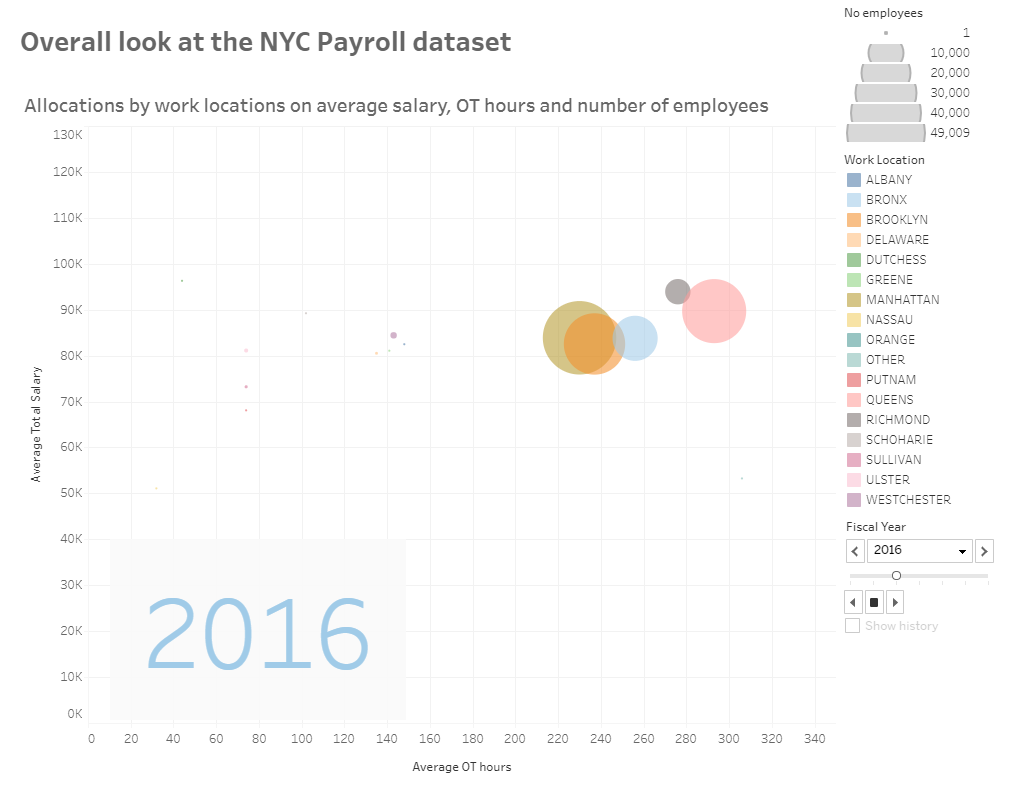

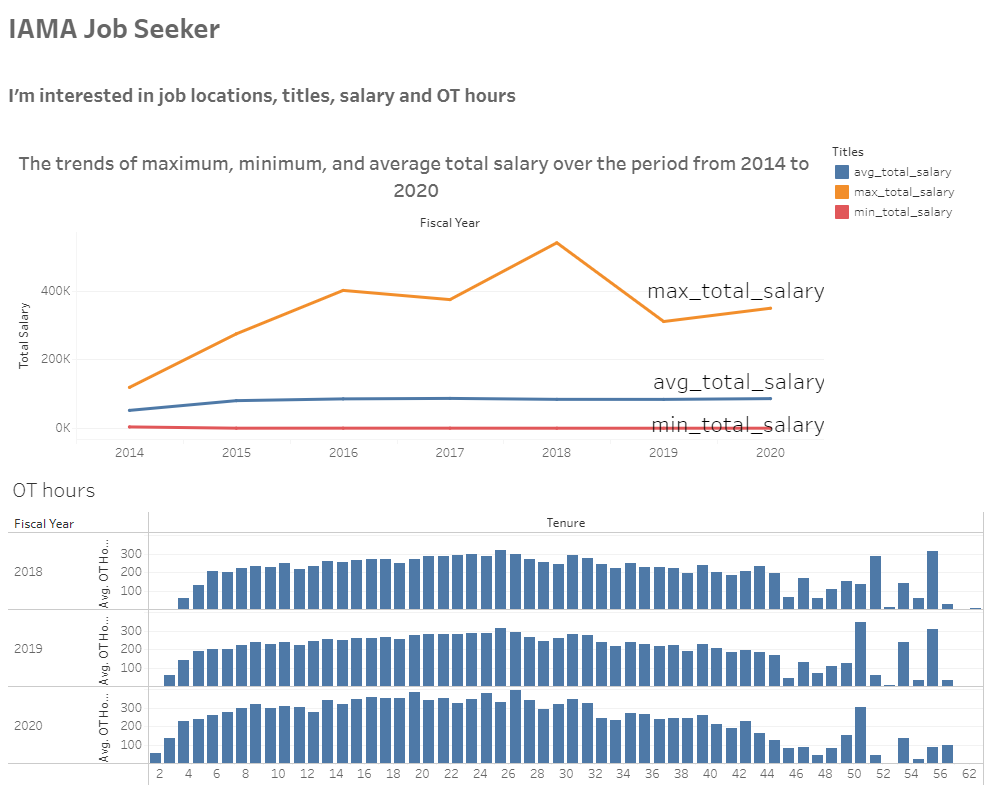

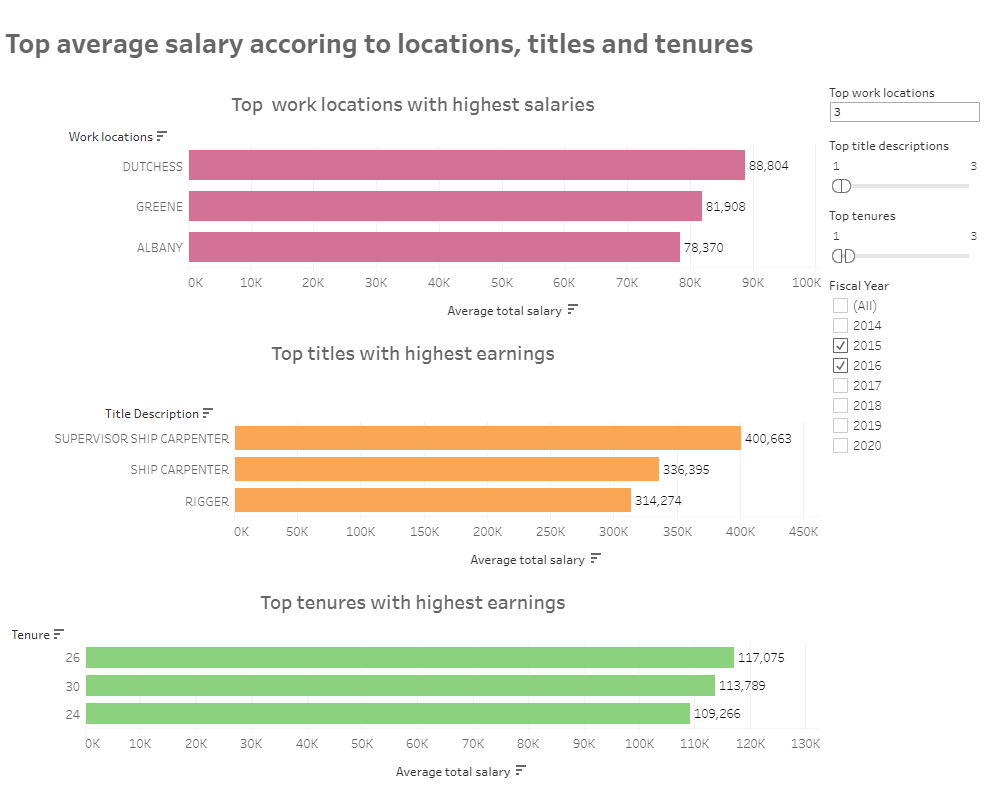

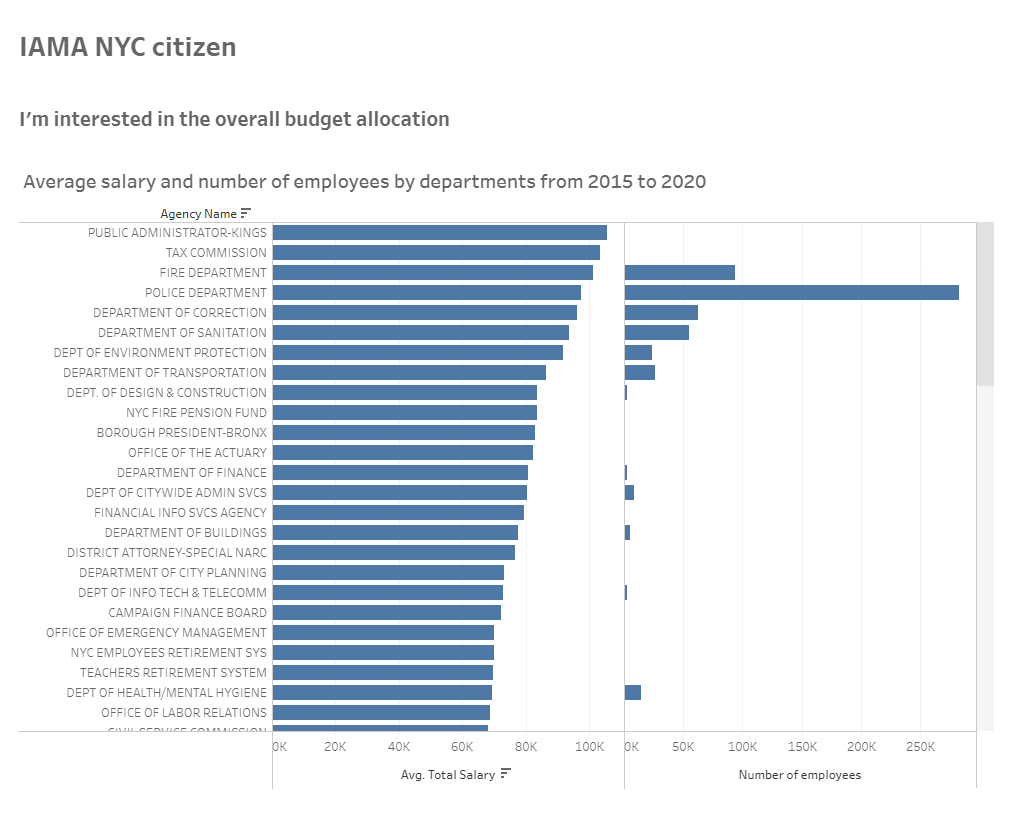

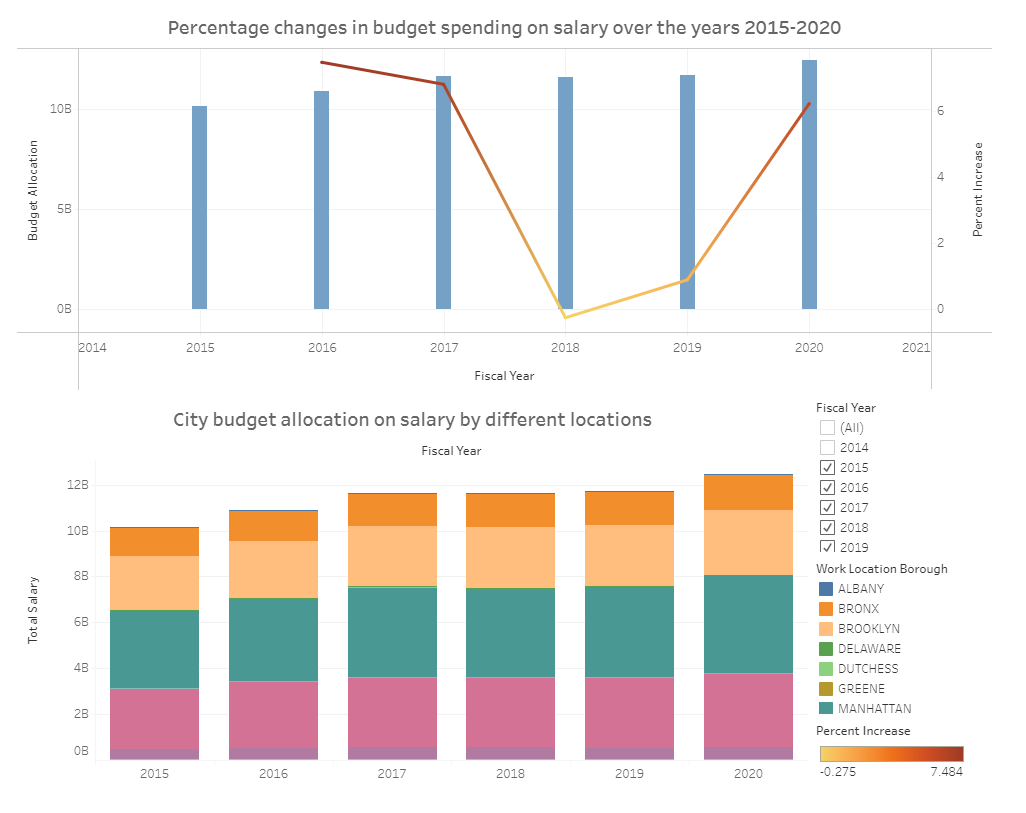

# Conclusion

We have used full data analytics cycle and explored that dataset by being in the roles of a job seeker and an NYC citizen. By being the job seeker, we have uncovered the salary and OT time trend in New York over the year of 2014-2020, and seen the top locations, top job titles and top tenures with the highest earnings. And by being the NYC citizen, we have researched on the allocation of NYC budget over different agencies and locations, with percentage change of budget spending each year. 

Furthermore, we have incorporated machine learning in our dataset in order to use tenure, regular work hours, OT hours and locations to predict gross salary. We have built 2 machine learning models, one with the location variable and one without, along with our own interpretation of results in each model. Our models still have limitations, but we hope they will shed some light on further research. 

Last of all, for data visualization we used Tableau Online and Tableau Public to visualize our data analytics research with dashboards and story. 

The links to data source and Tableau public are included in this notebook.